In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Training import GetDatasets
from Nets  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Simulation import buffer_simulation, save_obj, load_obj

tf.random.set_seed(1234)
np.random.seed(1234)

# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Get Dataset

In [2]:
trainBatchSize = testBatchSize = 1
trainSet,validSet,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Get Model

In [6]:
aging_active = [False]*29
MobileNet = GetNeuralNetworkModel('MobileNet',(224,224,3),8, quantization = False, aging_active=aging_active)
loss      = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
MobileNet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [5]:
for index,layer in enumerate(MobileNet.layers):
    print(index,layer.name)

0 input_1
1 lambda
2 lambda_1
3 zero_padding2d
4 conv2d
5 lambda_2
6 batch_normalization
7 re_lu
8 lambda_3
9 lambda_4
10 depthwise_conv2d
11 lambda_5
12 batch_normalization_1
13 re_lu_1
14 lambda_6
15 lambda_7
16 conv2d_1
17 lambda_8
18 batch_normalization_2
19 re_lu_2
20 lambda_9
21 lambda_10
22 zero_padding2d_1
23 depthwise_conv2d_1
24 lambda_11
25 batch_normalization_3
26 re_lu_3
27 lambda_12
28 lambda_13
29 conv2d_2
30 lambda_14
31 batch_normalization_4
32 re_lu_4
33 lambda_15
34 lambda_16
35 depthwise_conv2d_2
36 lambda_17
37 batch_normalization_5
38 re_lu_5
39 lambda_18
40 lambda_19
41 conv2d_3
42 lambda_20
43 batch_normalization_6
44 re_lu_6
45 lambda_21
46 lambda_22
47 zero_padding2d_2
48 depthwise_conv2d_3
49 lambda_23
50 batch_normalization_7
51 re_lu_7
52 lambda_24
53 lambda_25
54 conv2d_4
55 lambda_26
56 batch_normalization_8
57 re_lu_8
58 lambda_27
59 lambda_28
60 depthwise_conv2d_4
61 lambda_29
62 batch_normalization_9
63 re_lu_9
64 lambda_30
65 lambda_31
66 conv2d_5
67 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Training

In [9]:
# Early Stopping
# --------------
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
MobileNet.fit(x=trainSet,epochs=100,
            steps_per_epoch  =int(np.ceil(trainSize / trainBatchSize)),
            validation_data  =validSet,
            validation_steps =int(np.ceil(validSize/ trainBatchSize)), 
            callbacks=[earlyStop])

In [7]:
(OrigLoss,OrigAcc) = MobileNet.evaluate(testSet)

24/24 [==============================] - 11s 407ms/step - loss: 2.0794 - accuracy: 0.1173


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Save/Load Weigths

In [4]:
cwd = os.getcwd()
wgtDir = os.path.join(cwd, 'Data')
wgtDir = os.path.join(wgtDir, 'Trained Weights')
wgtDir = os.path.join(wgtDir, 'MobileNet')
wgtDir = os.path.join(wgtDir, 'Colorectal Dataset')
wgtDir = os.path.join(wgtDir,'Weights')
MobileNet.load_weights(wgtDir)

# 2) Stats

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  e) Activation Stats

In [5]:
ActivationStats(MobileNet,testSet,11,4,24)

169050464
338100928
507151392
676201856
845252320
1014302784
1183353248
1352403712
1521454176
1690504640
1859555104
2028605568
2197656032
2366706496
2535756960
2704807424
2873857888
3042908352
3211958816
3381009280
3550059744
3719110208
3888160672
3962120250
mean value (MMU): 0.019788127
mean value (Buffer): 0.3529078
maximum (MMU): 17.544662
minimum (MMU): -14.1065
maximum (Buffer): 6.0
minimum (Buffer): 0.0
saturation ratio (MMU): 3.6807022359214453e-09
saturation ratio (Buffer): 0.0
null bytes 1st ratio (Buffer): 0.02894620424506298
null bytes 2nd ratio (Buffer): 0.0
null bytes Both ratio (Buffer): 0.49494963813882226
# Bytes Nulos / # Bytes totales 0.5238958423838852


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  f) Write/Read Stats

In [3]:
Indices = [0,4,10,16,23,29,35,41,48,54,60,66,73,79,85,91,97,103,109,115,121,127,133,139,146,152,158,164,170,175]
Data    = GetReadAndWrites(MobileNet,Indices,817216,150,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(MobileNet,Indices,817216,150,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
CNN_gating_Acceses = pd.DataFrame(stats).reset_index(drop=False)
save_obj(Baseline_Acceses,'Data/Acceses/MobileNet/Baseline')
save_obj(CNN_gating_Acceses,'Data/Acceses/MobileNet/CNN_gating_Adj')

procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150
procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150


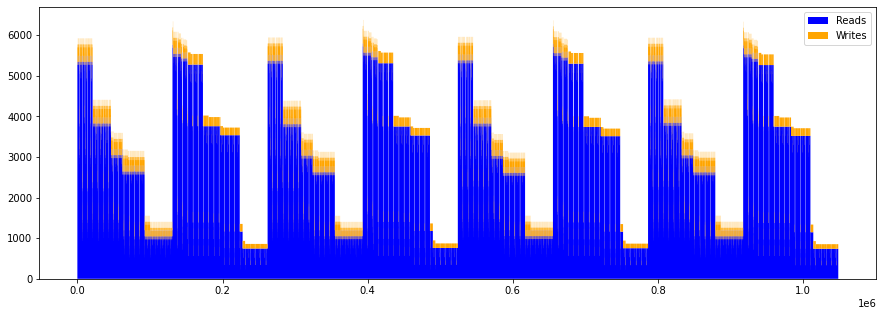

In [4]:
plt.figure(figsize=(15, 5))
plt.stackplot(CNN_gating_Acceses.to_dict()['index'].values(),
              CNN_gating_Acceses.to_dict()['Lecturas'].values(),
              CNN_gating_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

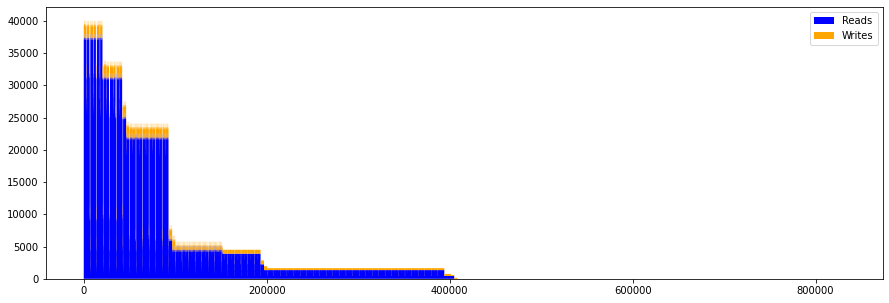

In [5]:
plt.figure(figsize=(15, 5))
plt.stackplot(Baseline_Acceses.to_dict()['index'].values(),
              Baseline_Acceses.to_dict()['Lecturas'].values(),
              Baseline_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

# 3) Quantization 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [31]:
CheckAccuracyAndLoss('MobileNet', testSet, wgtDir, aFracSize = 16, aIntSize = 16, wFracSize = 16, wIntSize = 16, 
                    inputShape = (224,224,3), outputShape = 8, batchSize = testBatchSize);

24/24 [==============================] - 2s 98ms/step - loss: 0.3642 - accuracy: 0.8720


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Number of bits analysis

In [ ]:
df = QuantizationEffect('MobileNet',testSet,wgtDir,(224,224,3),8,testBatchSize)
save_obj(df,'Data/Quantization/MobileNet/Colorectal Dataset/Quantization')

Estoy aquí en el efecto d ecuantización
Activation fraction part


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Used Config

In [7]:
CheckAccuracyAndLoss('MobileNet', testSet, wgtDir, aFracSize = 11, aIntSize = 4, wFracSize = 15, wIntSize = 0, 
                    inputShape = (224,224,3), outputShape = 8, batchSize = testBatchSize);

24/24 [==============================] - 3s 58ms/step - loss: 0.3807 - accuracy: 0.8760


# 3) Buffer Simulation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Baseline

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; CNN-Gated, case 2

In [3]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

QMobileNet  = GetNeuralNetworkModel('MobileNet',(224,224,3),8, quantization = True, aging=False, wordSize = 16, fracSize = 11)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
QMobileNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QMobileNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QMobileNet, fracBits = 14, intBits = 1)

    
LI = [0,4,10,16,23,29,35,41,48,54,60,66,73,79,85,91,97,103,109,115,121,127,133,139,146,152,158,164,170,175]
AI = [2,9,15,21,28,34,40,46,53,59,65,71,78,84,90,96,102,108,114,120,126,132,138,144,151,157,163,169,173,179]
buffer_simulation(QMobileNet,testSet, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 128,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/MobileNet/Colorectal Dataset/CNN-Gated/', buffer_size = 2*817216,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 102152, 204304, 306456, 408608, 510760, 612912, 715064, 817216]
Simulation Started, time: 07:21:38 cycles:  213771264 offset:  817216
procesed images: 128  time: 07:34:02 cycles:  215441352 offset:  817216
procesed images: 129  time: 07:37:19 cycles:  217111440 offset:  102152
procesed images: 130  time: 07:50:33 cycles:  218781528 offset:  102152
procesed images: 131  time: 07:53:53 cycles:  220451616 offset:  204304
procesed images: 132  time: 08:06:48 cycles:  222121704 offset:  204304
procesed images: 133  time: 08:10:14 cycles:  223791792 offset:  306456
procesed images: 134  time: 08:23:36 cycles:  225461880 offset:  306456
procesed images: 135  time: 08:26:59 cycles:  227131968 offset:  408608
procesed images: 136  time: 08:39:39 cycles:  228802056 offset:  408608
procesed images: 137  time: 08:42:57 cycles:  230472144 offset:  510760
procesed images: 138  time: 08:56:10 cycles:  232142232 offset:  510760
procesed images: 139  time: 08:59:30 cycles:  233812

({'Number of Addresses': 817216,
  'Data': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
  'HighCyclesCount': array([ 1566305,  1598626,  2211145, ..., 23131894, 23245462, 22401218],
        dtype=uint32),
  'OffCyclesCount': array([180056698, 180056698, 180056698, ..., 180025571, 180025571,
         180025571], dtype=uint32),
  'LowCyclesCount': array([68890197, 68857876, 68245357, ..., 47355735, 47242167, 48086411],
        dtype=uint32),
  'Flips': array([216, 233, 219, ..., 151, 152, 139], dtype=uint32),
  'offset': 306456},
 250513200)

# 4) Error Injection

In [4]:
trainBatchSize = testBatchSize = 64
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Checking the big sections

In [6]:
from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools

Start_from_zero = True

if Start_from_zero:
    Accs     = {0.00001:[],0.00005:[],0.0001:[]}
    Loss     = {0.00001:[],0.00005:[],0.0001:[]}
else:
    Accs     = load_obj('Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/Accs')
    Loss     = load_obj('Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/Loss')

network_size   = 817216*16
num_of_samples = 200
for Enumber in Accs:
    n_bits_fails = np.ceil(Enumber*network_size).astype(int)
    errors       = np.random.randint(0,2,n_bits_fails)
    buffer       = np.array(['x']*(network_size-n_bits_fails))
    buffer_with_errors = np.concatenate([buffer,errors])
    for index in range(0,num_of_samples):
        np.random.shuffle(buffer_with_errors)
        address_with_errors = np.reshape(buffer_with_errors,(-1,16))
        address_with_errors = ["".join(i) for i in address_with_errors]
        error_mask = [y for x
                      ,y in enumerate(address_with_errors) if y.count('x') < 16]
        locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        loss,acc   = CheckAccuracyAndLoss('MobileNet', test_dataset, wgtDir, outputShape=8, inputShape = (224,224,3),
                                            aFracSize = 11, aIntSize = 4, wFracSize = 15, wIntSize = 0,
                                            batchSize=testBatchSize, verbose = 0, aging = True,
                                            faultyAddresses = locs, maskedFaults = error_mask)
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    save_obj(Accs,'Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/Accs')
    save_obj(Loss,'Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/Loss')

1e-05 completada:  01:24:30
5e-05 completada:  02:20:23
0.0001 completada:  03:01:35


In [5]:
from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools

Start_from_zero = True

if Start_from_zero:
    Accs     = {0.00001:[],0.00005:[],0.0001:[]}
    Loss     = {0.00001:[],0.00005:[],0.0001:[]}
else:
    Accs     = load_obj('Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/weights Accs')
    Loss     = load_obj('Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/weights Loss')

    
network_size   = 1048576*16
num_of_samples = 200
for Enumber in Accs:
    n_bits_fails = np.ceil(Enumber*817216*16).astype(int)
    errors       = np.random.randint(0,2,n_bits_fails)
    buffer       = np.array(['x']*(network_size-n_bits_fails))
    buffer       = np.concatenate([buffer,errors])
    for index in range(0,num_of_samples):
        np.random.shuffle(buffer)
        address_with_errors = np.reshape(buffer,(-1,16))
        address_with_errors = ["".join(i) for i in address_with_errors]
        error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        del address_with_errors
        loss,acc   = CheckAccuracyAndLoss('MobileNet', test_dataset, wgtDir, outputShape=8, inputShape = (224,224,3),
                                            aFracSize = 11, aIntSize = 4, wFracSize = 15, wIntSize = 0,
                                            batchSize=testBatchSize, verbose = 0, aging = False, WeightsFaults = True,
                                            faultyAddresses = locs, maskedFaults = error_mask)
        print(index,' completados: ', datetime.now().strftime("%H:%M:%S"))
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    save_obj(Accs,'Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/weights Accs')
    save_obj(Loss,'Data/Errors/MobileNet/Colorectal Dataset/Uniform distribution/weights Loss')

0  completados:  17:16:51
1  completados:  17:17:01
2  completados:  17:17:10
3  completados:  17:17:20
4  completados:  17:17:29
5  completados:  17:17:39
6  completados:  17:17:48
7  completados:  17:17:58
8  completados:  17:18:08
9  completados:  17:18:17
10  completados:  17:18:27
11  completados:  17:18:37
12  completados:  17:18:47
13  completados:  17:18:56
14  completados:  17:19:06
15  completados:  17:19:16
16  completados:  17:19:26
17  completados:  17:19:36
18  completados:  17:19:45
19  completados:  17:19:55
20  completados:  17:20:05
21  completados:  17:20:14
22  completados:  17:20:24
23  completados:  17:20:34
24  completados:  17:20:43
25  completados:  17:20:53
26  completados:  17:21:03
27  completados:  17:21:13
28  completados:  17:21:23
29  completados:  17:21:33
30  completados:  17:21:42
31  completados:  17:21:52
32  completados:  17:22:02
33  completados:  17:22:11
34  completados:  17:22:22
35  completados:  17:22:32
36  completados:  17:22:42
37  complet

100  completados:  18:13:02
101  completados:  18:13:16
102  completados:  18:13:31
103  completados:  18:13:45
104  completados:  18:14:00
105  completados:  18:14:15
106  completados:  18:14:30
107  completados:  18:14:45
108  completados:  18:14:59
109  completados:  18:15:14
110  completados:  18:15:29
111  completados:  18:15:43
112  completados:  18:15:57
113  completados:  18:16:11
114  completados:  18:16:25
115  completados:  18:16:39
116  completados:  18:16:54
117  completados:  18:17:09
118  completados:  18:17:24
119  completados:  18:17:39
120  completados:  18:17:54
121  completados:  18:18:08
122  completados:  18:18:23
123  completados:  18:18:37
124  completados:  18:18:52
125  completados:  18:19:07
126  completados:  18:19:21
127  completados:  18:19:36
128  completados:  18:19:50
129  completados:  18:20:05
130  completados:  18:20:19
131  completados:  18:20:34
132  completados:  18:20:49
133  completados:  18:21:03
134  completados:  18:21:18
135  completados:  1

196  completados:  19:32:31
197  completados:  19:32:47
198  completados:  19:33:03
199  completados:  19:33:20
0.0001 completada:  19:33:20
